In [1]:
import pandas as pd
import numpy as np
import math
import time
import datetime as dt
import datetime
from scipy.stats import poisson
from scipy.stats import binom
from scipy.stats import nbinom
import matplotlib.pyplot as plt
import os

plt.rcParams['savefig.transparent']=False
plt.rcParams['savefig.facecolor']='white'

In [2]:
n_runs = 100

def add_median_CI2(DF):
    df = DF.copy()
    df['p1'] = df[[str(i) for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[str(i) for i in range(n_runs)]].median(axis=1)  
    df['p2'] = df[[str(i) for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

def add_median_CI(DF):
    df = DF.copy()
    df['p1'] = df[[i for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[i for i in range(n_runs)]].median(axis=1)  
    df['p2'] = df[[i for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

def aggregate_week(DF):
    y = DF.copy()
    y['date']=pd.to_datetime(y['time'],format='%Y-%m-%d')
    y = y.resample('W', on='date').sum() 
    y = y.reset_index()
    y2 = add_median_CI2(y)
    y2['week']=y2['date'].dt.isocalendar().week
    return y2

# choose folder

In [3]:
folder = './../transmission_model_with_empirical_matrices/'
#folder = './../transmission_model_with_synthetic_matrices/'

## title for plot of scaling factors
tag_title = folder.split('_')[-2]
tag_title

'empirical'

# 2020 and Alpha wave

In [4]:
folder_alpha = folder + '1_code_historical&alpha/output_hosp_adm/'

dict_alpha = {}

df = pd.read_csv(folder_alpha + 'new_H_admissions_by_age.csv')

for age,tag in enumerate(['ch', 'teen', 'adu', 'sen', 'all']):
    dict_alpha[tag] = df[['{}-median'.format(tag),
                            '{}-p1'.format(tag),
                            '{}-p2'.format(tag), 
                            'time']].copy()

dict_alpha['all'].head()

,all-median,all-p1,all-p2,time
0,0.0,0.0,0.000,2020-01-16
1,0.0,0.0,0.000,2020-01-17
2,0.0,0.0,0.000,2020-01-18
3,0.0,0.0,0.000,2020-01-19
4,0.0,0.0,0.525,2020-01-20


# merge delta wave

In [5]:
folder_delta = folder + '2_code_alpha&delta/output_hosp_adm/'

dict_delta = {}

df = pd.read_csv(folder_delta + 'new_H_admissions_by_age.csv')

for age,tag in enumerate(['ch', 'teen', 'adu', 'sen', 'all']):
    dict_delta[tag] = df[['{}-median'.format(tag),
                            '{}-p1'.format(tag),
                            '{}-p2'.format(tag), 
                            'time']].copy()

dict_delta['all'].head()

,all-median,all-p1,all-p2,time
0,0.0,0.0,0.0,2021-05-30
1,0.0,0.0,0.0,2021-05-31
2,0.0,0.0,0.0,2021-06-01
3,0.0,0.0,0.0,2021-06-02
4,0.0,0.0,0.0,2021-06-03


In [6]:
dict_alpha_delta = {}

change_point = '2021-06-14'  ## lunedì

for kk in dict_alpha.keys():
    dict_alpha_delta[kk] = dict_alpha[kk][dict_alpha[kk]['time']<change_point].copy()
    dict_alpha_delta[kk] = pd.concat((dict_alpha_delta[kk], 
                                      dict_delta[kk][dict_delta[kk]['time']>=change_point].copy())).reset_index(drop=True)

# merge omicron wave

In [7]:
folder_omicron = folder + '3_code_delta&omicron/output_hosp_adm/'

dict_omicron = {}

df = pd.read_csv(folder_omicron + 'new_H_admissions_by_age.csv')

for age,tag in enumerate(['ch', 'teen', 'adu', 'sen', 'all']):
    dict_omicron[tag] = df[['{}-median'.format(tag),
                            '{}-p1'.format(tag),
                            '{}-p2'.format(tag), 
                            'time']].copy()
    
dict_omicron['all'].head()

,all-median,all-p1,all-p2,time
0,0.0,0.0,0.0,2021-10-03
1,0.0,0.0,0.0,2021-10-04
2,0.0,0.0,0.0,2021-10-05
3,0.0,0.0,0.0,2021-10-06
4,0.0,0.0,0.0,2021-10-07


In [8]:
dict_alpha_delta_omicron = {}

change_point = '2021-10-11'  ## lunedi

for kk in dict_alpha_delta.keys():
    print(kk)
    dict_alpha_delta_omicron[kk] = dict_alpha_delta[kk][dict_alpha_delta[kk]['time']<change_point].copy()
    
    dict_alpha_delta_omicron[kk] = pd.concat((dict_alpha_delta_omicron[kk],
                        dict_omicron[kk][dict_omicron[kk]['time']>=change_point])).reset_index(drop=True)

ch
teen
adu
sen
all


# plot with data hosp

In [9]:
data_by_age = pd.read_csv('./../other_inputs/SIVIC_data_region_ageclass_20221212.csv')
data_by_age = data_by_age[data_by_age['date']<='2022-05-22']

data_by_age.age.unique()

array(['[0,11)', '[11,19)', '[19,40)', '[40,65)', '[65,75)', '[75,120]',
       'missing'], dtype=object)

In [10]:
regs = ['ARA', 'BFC', 'BRE', 'GES', 'HDF', 'IDF','OCC', 'PAC','NOR', 'PDL', 'CVL', 'NAQ', 'COR']
len(regs)

# filter on regions of metropolitan france
data_by_age = data_by_age[data_by_age['region'].isin(regs)]

interval = ['[0,11)', '[11,19)', '[19,40)', '[40,65)', '[65,120)', None]

hosp_pred = {}

hosp_pred['all'] = data_by_age.groupby('date').sum().reset_index()[['date','hosp_pred']].reset_index(drop=True)
hosp_pred['ch'] = data_by_age[data_by_age.age.isin(['[0,11)'])][['date','hosp_pred']].groupby('date').sum().reset_index()
hosp_pred['teen'] = data_by_age[data_by_age.age.isin(['[11,19)'])][['date','hosp_pred']].groupby('date').sum().reset_index()
hosp_pred['adu'] = data_by_age[data_by_age.age.isin(['[19,40)', '[40,65)'])].groupby('date').sum().reset_index()[['date','hosp_pred']].reset_index()
hosp_pred['sen'] = data_by_age[data_by_age.age.isin(['[65,75)', '[75,120]'])][['date','hosp_pred']].groupby('date').sum().reset_index()

In [11]:
for kk in ['all', 'ch', 'teen', 'adu', 'sen']:
    print(kk)
    dict_alpha_delta_omicron[kk] = dict_alpha_delta_omicron[kk].merge(hosp_pred[kk],
                                                    left_on='time', right_on='date', how='outer')
    dict_alpha_delta_omicron[kk]['date'] = dict_alpha_delta_omicron[kk]['date'].fillna(dict_alpha_delta_omicron[kk]['time'])    
    dict_alpha_delta_omicron[kk]['time'] = dict_alpha_delta_omicron[kk]['time'].fillna(dict_alpha_delta_omicron[kk]['date'])    

all
ch
teen
adu
sen


In [12]:
deeppurple = "#3d348b"
seagreen = "#4C934C"
magenta = "#D81E5B"
lakeblue = "#4F86C6"

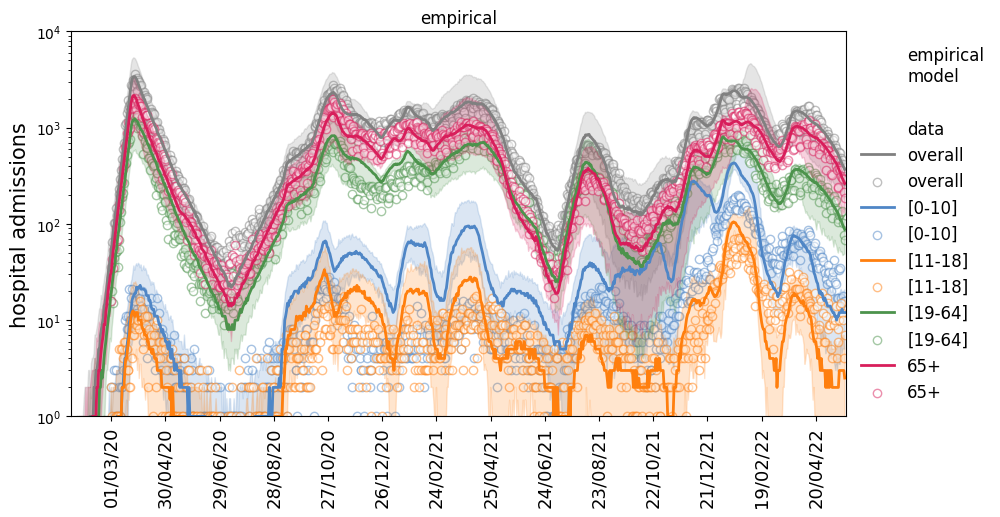

In [13]:
plt.figure(figsize=(10,5))

df = dict_alpha_delta_omicron.copy()

cols = ['grey', 'tab:blue', 'tab:green', 'tab:orange', 'purple']
cols = ['grey', lakeblue, 'tab:orange', seagreen, magenta]
lab_tag = dict(zip(['all', 'ch', 'teen','adu','sen'],
                   ['overall', '[0-10]', '[11-18]', '[19-64]', '65+']))

plt.plot([],[], color='white',label='{}\nmodel'.format(tag_title))
plt.scatter([],[], color='white',label=' ')
plt.scatter([],[], color='white',label='data')

for h, age in enumerate(['all', 'ch', 'teen','adu','sen']):  
    plt.plot(df[age][age+'-median'], label = lab_tag[age], color=cols[h], linewidth = 2)
    plt.scatter(df[age].index, df[age]['hosp_pred'], label = lab_tag[age], edgecolor=cols[h], alpha = 0.5, facecolor='white')

    plt.fill_between(df[age].index, 
                     df[age][age+'-p1'],
                     df[age][age+'-p2'], alpha = 0.2, color=cols[h])
    
df = df[age]

move = 45
step = 60
end = len(df)
dates=pd.to_datetime(df['time']).apply(lambda x:x.strftime("%d/%m/%y"))
plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
           rotation=90, fontsize=13) 

plt.legend(frameon=False, loc='upper left', 
           bbox_to_anchor=(1,1), fontsize=12)

plt.ylim([1, 10000])
plt.xlim([0, len(df)])
plt.ylabel('hospital admissions', fontsize=15)

plt.yscale('log')
plt.title(tag_title)
#plt.savefig('hosp_traj/hosp_age_log_{}.png'.format(tag_title), 
#            bbox_inches='tight',dpi=300)
plt.show()

# save outputs

In [14]:
folder

'./../transmission_model_with_empirical_matrices/'

In [15]:
for kk in ['ch', 'teen', 'adu', 'sen', 'all']:
    dict_alpha_delta_omicron[kk].to_csv(folder + 'daily_hosp_model_full_traj_{}.csv'.format(kk), index=False)  

# comparison trajectory

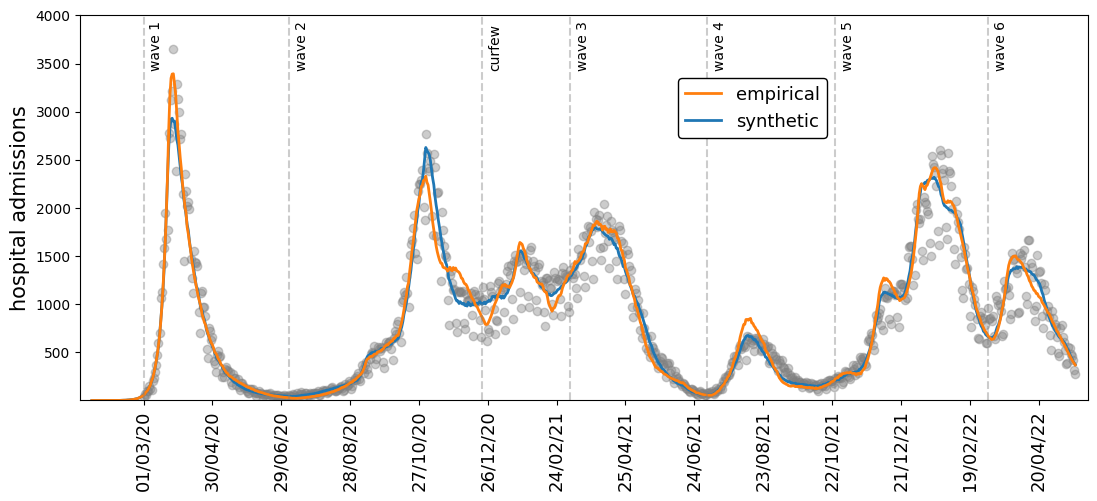

In [16]:
plt.figure(figsize=(13,5))
folders = ['./../transmission_model_with_synthetic_matrices/', 
          './../transmission_model_with_empirical_matrices/'] 
tags = dict(zip(folders, [f.split('_')[-2] for f in folders]))

for folder in folders:
    df = {}
    df['all'] = pd.read_csv(folder+ 'daily_hosp_model_full_traj_{}.csv'.format('all'))
    for h, age in enumerate(['all']):  
        plt.plot(df[age][age+'-median'], 
             label = tags[folder], linewidth = 2)  
        
plt.scatter(df[age].index, df[age]['hosp_pred'], label = 'data', color='gray', alpha = 0.4)
    
df = df[age]
move = 45
step = 60
end = len(df)
dates=pd.to_datetime(df['time']).apply(lambda x:x.strftime("%d/%m/%y"))
plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
           rotation=90, fontsize=13) 

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
#order = [3,0,1,2]
order = [1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           frameon=True, loc='upper right', fontsize=13, bbox_to_anchor = (0.75,0.86), 
           facecolor='white', edgecolor="black", framealpha=1)

#windows = [('2020-03-01', '2020-07-09'),
#           ('2020-07-10', '2020-12-31'), 
#           ('2021-01-01', '2021-02-18'), 
#           ('2021-02-19', '2021-07-08'), 
#           ('2021-07-09', '2021-10-28'),
#           ('2021-10-28', '2022-02-28'),
#           ('2022-03-01', '2022-05-22')]

windows = [('2020-03-01', '2020-07-05'),
           ('2020-07-06', '2020-12-20'), 
           ('2020-12-21', '2021-03-07'), 
           ('2021-03-08', '2021-07-04'), 
           ('2021-07-05', '2021-10-24'),
           ('2021-10-25', '2022-03-06'),
           ('2022-03-07', '2022-05-22')]

tag_windows = ['wave 1', 'wave 2', 'curfew', 
               'wave 3 ', 'wave 4 ', 
               'wave 5 ', 'wave 6 ']

for s,w in enumerate(windows):
    plt.axvline(x=df[df['date']==w[0]].index, linestyle = '--', color='grey', alpha = 0.4)
    plt.text(df[df['date']==w[0]].index[0]+5, 3450, tag_windows[s], ha = 'left', zorder=10, rotation=90)

plt.ylim([1, 4000])
plt.xlim([-10, len(df)+10])
plt.ylabel('hospital admissions', fontsize=15)
plt.show()